# DataFrame Operations

## About the Data

In this notebook, we will be working with 2 data sets:
- Facebook's stock price throughout 2018 (obtained using the stock_analysis package).
- daily weather data for NYC from the National Centers for Environmental Information (NCEI) API.

Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

## Background on the weather data

Data meanings:
- AWND : average wind speed
- PRCP : precipitation in millimeters
- SNOW : snowfall in millimeters
- SNWD : snow depth in millimeters
- TMAX : maximum daily temperature in Celsius
- TMIN : minimum daily temperature in Celsius

## Setup

In [ ]:
import numpy as np
import pandas as pd

weather = pd.read_csv('/content/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

In [ ]:
fb = pd.read_csv('/content/fb_2018.csv', index_col = 'date', parse_dates=True)
fb.head()

## Arithmetic and statistics

We already saw that we can use mathematical operators like + and / with dataframes directly. However, we can also use methods, which allow us to specify the axis to
perform the calculation over. By default this is per column. Let's find the z-scores for the volume traded and look at the days where this was more than 3 standard deviations
from the mean:

In [ ]:
fb.assign(
    abs_z_score_volume = lambda x:x.volume.sub(x.volume.mean()).div(x.volume.std()).abs() # sub() for sbtraction, div() for floor division
).query('abs_z_score_volume > 3')

We can use rank() and pct_change() to see which days had the largest change in volume traded from the day before:

In [ ]:
fb.assign(
    volume_pct_change = fb.volume.pct_change(),
    pct_change_rank = lambda x: x.volume_pct_change.abs().rank(  # percent change
        ascending = False
    )
).nsmallest(5, 'pct_change_rank')

January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that
Facebook's advertising is a key component of its business (nearly 89% in 2017), many shares were sold and the price dropped in panic:

In [ ]:
fb['2018-01-11':'2018-01-12']

Throughout 2018, Facebook's stock price never had a low above $215:

In [ ]:
(fb > 215).any()

Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:

In [ ]:
(fb > 215).all()

## Binning and thresholds

When working with the volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [ ]:
(fb.volume.value_counts() > 1).sum()

We can use pd.cut() to create 3 bins of even an even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:

In [ ]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

In [ ]:
fb[volume_binned == 'high'].sort_values(
'volume', ascending=False
)

July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:

In [ ]:
fb['2018-07-25':'2018-07-26']

Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers

In [ ]:
fb['2018-03-16':'2018-03-20']

Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin.
Note: visualizations will be covered in chapters 5 and 6.

In [ ]:
import matplotlib.pyplot as plt
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
  plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
  plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use qcut() . We will make 4 quartiles

In [ ]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

Notice the bins don't cover ranges of the same size anymore

In [ ]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
  plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
  plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
plt.ylabel('volume traded')
plt.legend()
plt.show()

Sometimes we don't want to make bins, but rather cap values at a threshold. Before we look at an example, let's pivot our weather data for the Central Park station:

In [ ]:
central_park_weather = weather.query(
'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

In [ ]:
central_park_weather.head()

Say we don't care how much snow their was, just that it snowed in Central Park. However, we don't want to make a Boolean column since we need to preserve the data type of
float. We can use clip() to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold. This means we
can use clip(0, 1) to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park. Preserving the data type will
save some work later on if we are building a model:

In [ ]:
central_park_weather.SNOW.clip(0, 1).value_counts()

Note: the clip() method can also be called on the dataframe itself.

## Applying Functions

We can use the apply() method to run the same operation on all columns (or rows) of the dataframe. Let's calculate the z-scores of the TMIN, TMAX, and PRCP
observations in Central Park in October 2018:

In [ ]:
oct_weather_z_scores = central_park_weather.loc[
'2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T # describe(*) gives you the min,max, 25,50, 75 %

October 27th rained much more than the rest of the days:

In [ ]:
oct_weather_z_scores.query('PRCP > 3')

Indeed, this day was much higher than the rest:

In [ ]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

When the function we want to apply isn't vectorized, we can:
- use np.vectorize() to vectorize it (similar to how map() works) and then use it with apply()
- use applymap() and pass it the non-vectorized function directly
Say we wanted to count the digits of the whole numbers for the Facebook data. len() is not vectorized:

In [ ]:
import numpy as np

fb.apply(
  lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
  fb.applymap(lambda x: len(str(np.ceil(x))))
)

A simple operation of addition to each element in a series grows linearly in time complexity when using iteritems() , but stays near 0 when using vectorized operations.
iteritems() and related methods should only be used if there is no vectorized solution:

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
  test = pd.Series(np.random.uniform(size=size))

  start = time.time()
  x = test + 10
  end = time.time()
  vectorized_results[size] = end - start

  start = time.time()
  x = []
  for i, v in test.iteritems():
    x.append(v + 10)
  x = pd.Series(x)
  end = time.time()
  iteritems_results[size] = end - start

pd.DataFrame(
  [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

## Window Calculations

Consult the understanding windows calculation notebook for interactive visualizations to help understand window calculations.

The rolling() method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation
function (sum here):

In [ ]:
central_park_weather['2018-10'].assign(
  rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

In [ ]:
central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

We can use different aggregation functions per column if we use agg() instead. We pass in a dictionary mapping the column to the aggregation to perform on it:

In [ ]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
  {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
  central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
  lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

Rolling calculations ( rolling() ) use a sliding window. Expanding calculations ( expanding() ) however grow in size. These are equivalent to cumulative aggregations like
cumsum() ; however, we can specify the minimum number of periods required to start calculating (default is 1):

In [ ]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

Separate expanding aggregations per column. Note that agg() will accept numpy functions too:

In [ ]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
  {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
  central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
  lsuffix='_expanding'
).sort_index(axis=1)

We can calculate the exponentially weighted moving average as follows. Note that span here is the periods to use:

In [ ]:
fb.assign(
  close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

Consult the understanding_window_calculations.ipynb notebook for interactive visualizations to help understand window calculations.

## Pipes

Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of if
they are methods or functions:

We can pass any function that will accept the caller of pipe() as the first argument:

In [ ]:
def get_info(df):
  return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())

fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
  == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

For example, passing pd.DataFrame.rolling to pipe() is equivalent to calling rolling() directly on the dataframe, except we have more flexiblity to change this:

In [ ]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

The pipe takes the function passed in and calls it with the object that called pipe() as the first argument. Positional and keyword arguments are passed down

In [ ]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

We can use a pipe to make a function that we can use for all our window calculation needs:

In [ ]:
from window_calc import window_calc
window_calc??

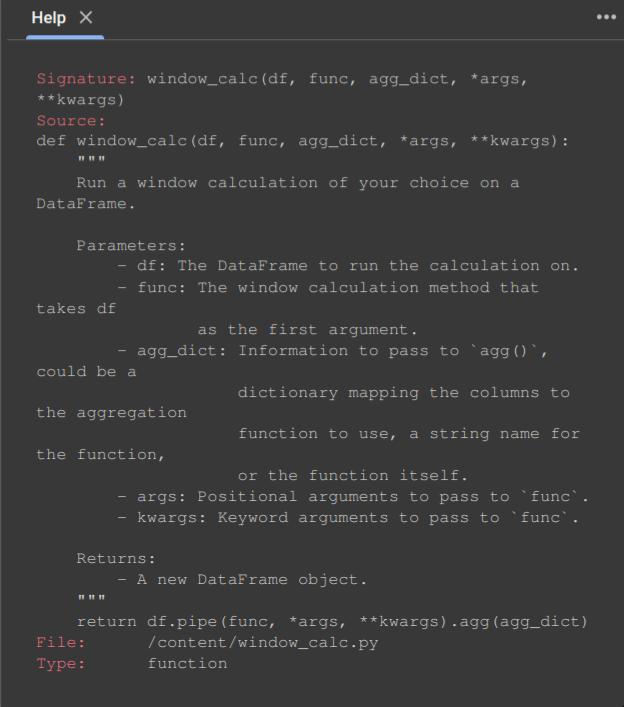

We can use the same interface to calculate various window calculations now. Let's find the expanding median for the Facebook data:

In [ ]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

Using the exponentially weighted moving average requires we pass in a keyword argument

In [ ]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

With rolling calculations, we can pass in a positional argument for the window size:

In [ ]:
window_calc(
  central_park_weather['2018-10'],
  pd.DataFrame.rolling,
  {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
  '3D'
).head()